# Steam Games Review Analysis

Modified From: https://www.kaggle.com/code/danielbeltsazar/steam-games-reviews-analysis-sentiment-analysis

Treat this as the temporary training script.

TF-IDF + Random Forest Classifier. Two classes [positive, negative]

The ratings of a product are reflected in the comments or reviews. In the advanced sentiment analysis for the product rating system, comments are analyzed to detect the hidden sentiments. In this case, comments about gaming experience in steam platform will be analyzed.

Sentiment analysis using machine learning takes the help of a database comprising sentiment-based words that include both positive and negative keywords. 

The words used in the user comments section is compared to the words contained in the database and an evaluation is made. By comparing with the keywords in the database, the system specifies whether the product is good, bad, or worst.

# 1. Install and Import Necessary Libray For NLP and Sentiment Analysis

In [1]:
# %%capture
# !pip install stopwords
# !pip install flair
# !pip install nltk
# !pip install swifter

In [2]:
import pandas as pd
import numpy as np
# import flair
# from flair.data import Sentence
import re
import nltk
from nltk.corpus import stopwords
# from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random as rn
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image
from datetime import datetime
pd.options.display.max_rows = None

# 2. Import Steam Games Review Dataset


### Here i'm just taking 2% of our data to analyze and to be trained.

In [3]:
rn.seed(a=40)
p = 0.02

from pathlib import Path
dataset_path = Path('../../dataset/sa/dataset.csv').resolve()

review = pd.read_csv(dataset_path,skiprows=lambda i: i>0 and rn.random() > p)
review.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Graphics is not everything! :) Old school love.,1,1
1,10,Counter-Strike,Played it over 2000hours..woah.. all i can say...,1,0
2,10,Counter-Strike,Think you got skills because you came from CS:...,1,1
3,10,Counter-Strike,"Game of my childhood. It was the year 1998, i...",1,0
4,10,Counter-Strike,Where it all started :) A true classic to the ...,1,0


### Here i'm taking 10% of our data to be used as our model validation.

In [4]:
rn.seed(a=40)
q = 0.1  
review_val = pd.read_csv(dataset_path,skiprows=lambda i: i>0 and rn.random() > q)
review_val.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,This game saved my virginity.,1,0
1,10,Counter-Strike,Fire in the Hole Simulator 1999,1,0
2,10,Counter-Strike,Best game ever! Started my gaming addiction :D,1,1
3,10,Counter-Strike,'Lock and Load.' 'Go go go!' 'Fire in the hole...,1,0
4,10,Counter-Strike,Nice oldschool game! Counter-Strike is very co...,1,1


In [5]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128153 entries, 0 to 128152
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   app_id        128153 non-null  int64 
 1   app_name      124366 non-null  object
 2   review_text   128004 non-null  object
 3   review_score  128153 non-null  int64 
 4   review_votes  128153 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 4.9+ MB


In [6]:
review.review_text = review.review_text.astype('str')

In [7]:
# replace -1 to 0
# then 0 = negative, 1 = positive
# for easier processing
review['review_score'] = review['review_score'].replace(-1, 0)
review_val['review_score'] = review_val['review_score'].replace(-1, 0)

In [8]:
review_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640987 entries, 0 to 640986
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   app_id        640987 non-null  int64 
 1   app_name      622464 non-null  object
 2   review_text   640283 non-null  object
 3   review_score  640987 non-null  int64 
 4   review_votes  640987 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 24.5+ MB


# 3. Analysis and Visualization


## 3.1. Distribution of Reviews in Each Sentiment

In [9]:
temp = review.groupby('review_score').count()['review_text'].reset_index().sort_values(by='review_text',ascending=False)
temp.style.background_gradient(cmap='Purples')


,review_score,review_text
1,1,104694
0,0,23459


### We will see the visualization of it.

/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='review_score', ylabel='count'>

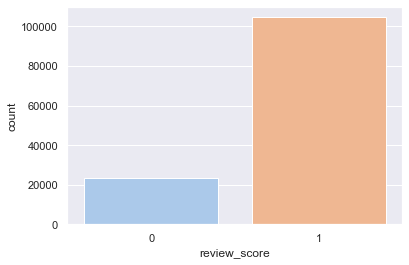

In [10]:
# sns.set_theme(style='whitegrid')
plt.style.use("dark_background")
sns.set(rc = {'figure.figsize':(13,8)})
sns.set_palette("pastel")
sns.countplot(x='review_score',data=review)

### We can see that there are more positive sentiment reviews than negative sentiment reviews.

## 3.4. Distribution of Number of Review Words

### First we create additional features to count number of words in each review text

In [11]:
review_vis = review.copy()

In [12]:
review_vis['Num_word_review'] = review_vis['review_text'].apply(lambda x:len(str(x).split()))

### Than we can plot them

/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Num_word_review', ylabel='Count'>

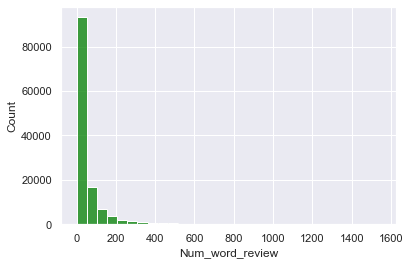

In [13]:
sns.histplot(data=review_vis, x="Num_word_review",bins=30,color='green')

### As we can see that most of our review texts contain 1-200 words.

## 3.5. Distribution of Words in All Review Texts

In [14]:
review_vis['temp_list'] = review_vis['review_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in review_vis['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,the,276424
1,and,186298
2,a,175388
3,to,174542
4,of,133863
5,is,123576
6,game,113869
7,I,112255
8,you,106759
9,it,85241


### Of course this list still contains stopwords which we have not filtered yet. We will see them later after we filter our review texts.

# 4. Data Cleaning For Sentiment Processing

In [15]:
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
nltk.download('stopwords')
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michaelcheng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Null values Cleaning

In [16]:
review.isnull().sum()

app_id             0
app_name        3787
review_text        0
review_score       0
review_votes       0
dtype: int64

### But after we've seen that the missing values are only in app name feature, we will ignore them anyway.

Note: Data preprocessing is a creative process and has no single definite workflow to it.

But for NLP, usually involves stemming, lemmatizing, removing special characters, removing stopwords (which has little to none impact to the overall meaning of the sentence.), removing punctuation, lower casing words etc...

### Duplicate Values Removing

In [17]:
review = review.drop_duplicates(keep='first')

In [18]:
review.shape

(109075, 5)

### We make a function to clean some basic characters

In [19]:
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

### We make function to remove numeric

In [20]:
def remove_num(texts):
   output = re.sub(r'\d+', '', texts)
   return output

### We make function to remove emoji

In [21]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

### We make function to unify whitespaces

In [22]:
def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string 

### We make function to remove symbols

In [23]:
def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', x)
    return cleaned_string

### We make function to remove punctuation

In [24]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',','))
    return final

### We make function to remove stopwords

Stopwords are words that occur frequently in a language and are often grammatical in nature, such as articles (e.g., "the," "a"), prepositions (e.g., "in," "on"), conjunctions (e.g., "and," "but"), and pronouns (e.g., "he," "she"). These words are necessary for constructing sentences and conveying grammatical structure, but they often do not contribute much to the overall meaning of the text.

- noise reduction
- Improved Analysis Accuracy
- faster processing

In [25]:
stop=set(stopwords.words("english"))
stemmer=PorterStemmer()
lemma=WordNetLemmatizer()

def remove_stopword(text):
   text=[word.lower() for word in text.split() if word.lower() not in stop]
   return " ".join(text)

### We make function to use stemming to normalize words

Reduce the words to its stem to reduce dimension.
e.g. 

cared ----> care

university ----> univers

fairly ----> fair

easily ----> easili

singing ----> sing

sings ----> sing

sung ----> sung

singer ----> singer

sportingly ----> sport

In [26]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
def stemming(text):
   stem=[]
   # stopword = stopwords.words('english')
   snowball_stemmer = SnowballStemmer('english')
   word_tokens = nltk.word_tokenize(text)
   stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
   stem=' '.join(stemmed_word)
   return stem

### Then we combine all the cleaning functions

In [27]:
def cleaning(df,review):
    df[review] = df[review].apply(clean)
    df[review] = df[review].apply(deEmojify)
    df[review] = df[review].str.lower()
    df[review] = df[review].apply(remove_num)
    df[review] = df[review].apply(remove_symbols)
    df[review] = df[review].apply(remove_punctuation)
    df[review] = df[review].apply(remove_stopword)
    df[review] = df[review].apply(unify_whitespaces)
    df[review] = df[review].apply(stemming)

In [28]:
cleaning(review,'review_text')

In [29]:
review[['review_text']].head(20)

,review_text
0,graphic everyth old school love
1,play hourswoah say isthisi old gold let go eve...
2,think got skill came cs go think got skill cau...
3,game childhood year pentium pc month upgrad dx...
4,start true classic counter strike seri never g...
5,play game year year non steam still amaz fact ...
6,old still best
7,nice game
8,great
9,play awesom game grow oh ya boy miss


### Now all the cleanings are done. We will try to visualize the common words distribution of our review texts. We have done it before but our previous review texts still contain stopwords and punctuations.

In [30]:
review_vis2 = review.copy()

In [31]:
review_vis2['temp_list'] = review_vis2['review_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in review_vis2['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,game,189136
1,play,55324
2,like,39450
3,get,33243
4,one,27061
5,good,26695
6,time,25745
7,fun,24913
8,realli,21775
9,great,21689


### We can plot them

/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='count', ylabel='Common_words'>

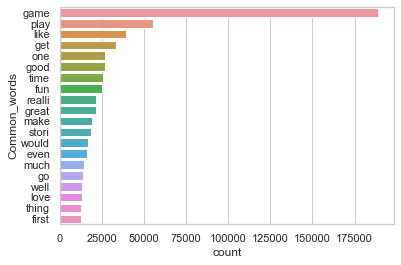

In [32]:
sns.set_theme(style="whitegrid")
sns.barplot(x="count", y="Common_words", data=temp)

### Then We can see that the word "game" , "play" , "like" are the top 3 common words in our review texts.

# 5. Creating Bag of Words and Text Classifier Model

## 5.1. Creating pipeline for tokenizing and modelling

### Here i use count vectorizer for tokenizing and random forest as classifier model.

can use other models, such as Adaboost, XGBoost, logistric

The author uses TF-IDF -> Random Forest classifier to build the sentiment classification.

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier

cnt_vect_unbalanced = CountVectorizer(stop_words= "english",max_features=4000)
tfidf_unbalanced = TfidfTransformer()
rf_classifier_unbalanced = RandomForestClassifier()

clf = Pipeline([
    ('vect', cnt_vect_unbalanced),
    ('tfidf', tfidf_unbalanced),
    ('classifier', rf_classifier_unbalanced),
    ])

In [34]:
X = review['review_text']
y = review['review_score']

In [35]:
from collections import Counter
Counter(y)

Counter({1: 89326, 0: 19749})

## 5.2. Tokenizing and Model Training

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 40,
                                                   test_size = 0.20)


In [37]:
text_classifier = clf.fit(X_train,y_train)

In [38]:
# get both probability and labels
# the probability is for ploting ROC

predictions_probability_raw = text_classifier.predict_proba(X_test)
# predictions = text_classifier.predict(X_test)
predictions = np.argmax(predictions_probability_raw, axis=1)

# creating single class label probability for ploting ROC curve
predictions_probability = predictions_probability_raw if len(np.unique(y_test)) > 2 else np.array([predictions_probability_raw[i, pred] for i, pred in enumerate(list(predictions))])

## 5.3. Model's Performance

Include showing F1 score, accuracy etc, and ROC curve graphs

In [39]:
# find accuracy, precision, recall:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
confusion_matrix(y_test,predictions)

array([[ 1229,  2722],
       [  415, 17449]])

In [40]:
def Confusion_Matrix(y_test,ypred):
    cfmat = confusion_matrix(y_test,ypred)
    print('Confusion Matrix: \n',classification_report(y_test,ypred))
    print("\n")
    print('TN - True Negative {}'.format(cfmat[0,0]))
    print('FP - False Positive {}'.format(cfmat[0,1]))
    print('FN - False Negative {}'.format(cfmat[1,0]))
    print('TP - True Positive {}'.format(cfmat[1,1]))
    print('Accuracy Rate: {}'.format(np.divide(np.sum([cfmat[0,0],cfmat[1,1]]),np.sum(cfmat))))
    print('Misclassification Rate: {}'.format(np.divide(np.sum([cfmat[0,1],cfmat[1,0]]),np.sum(cfmat))))
    print('F1-Score: {}'.format(f1_score(y_test, ypred,average='macro')))
    print('ROC-AUC {}'.format(roc_auc_score(y_test,ypred)))

In [41]:
Confusion_Matrix(y_test,predictions)

Confusion Matrix: 
               precision    recall  f1-score   support

           0       0.75      0.31      0.44      3951
           1       0.87      0.98      0.92     17864

    accuracy                           0.86     21815
   macro avg       0.81      0.64      0.68     21815
weighted avg       0.84      0.86      0.83     21815



TN - True Negative 1229
FP - False Positive 2722
FN - False Negative 415
TP - True Positive 17449
Accuracy Rate: 0.856199862479945
Misclassification Rate: 0.14380013752005502
F1-Score: 0.6784220779670858
ROC-AUC 0.6439147058746855


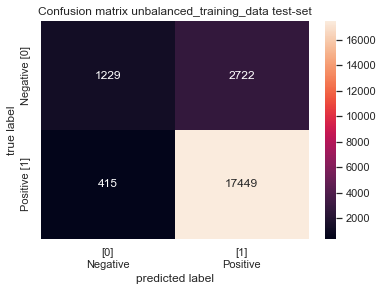

In [47]:
sns.set_style()
ax = sns.heatmap(confusion_matrix(y_test,predictions),annot=True,fmt='')

ax.set_title('Confusion matrix unbalanced_training_data test-set')
ax.set_xlabel("predicted label")
ax.set_ylabel('true label')
ax.set_xticklabels(['[0]\nNegative', '[1]\nPositive'])
ax.set_yticklabels(['Negative [0]', 'Positive [1]'])



save=True
if save:
    # note that savefig has different settings than ploting in python
    # have to declare it manually
    # https://stackoverflow.com/questions/53727761/black-background-behind-a-figures-labels-and-ticks-after-saving-figure-but-not
    plt.savefig(f'steam-games-reviews-analysis-sentiment-analysis_confusion-matrix_{datetime.now().strftime("%Y%m%d%H%M%S")}.png', dpi=600, facecolor='w')

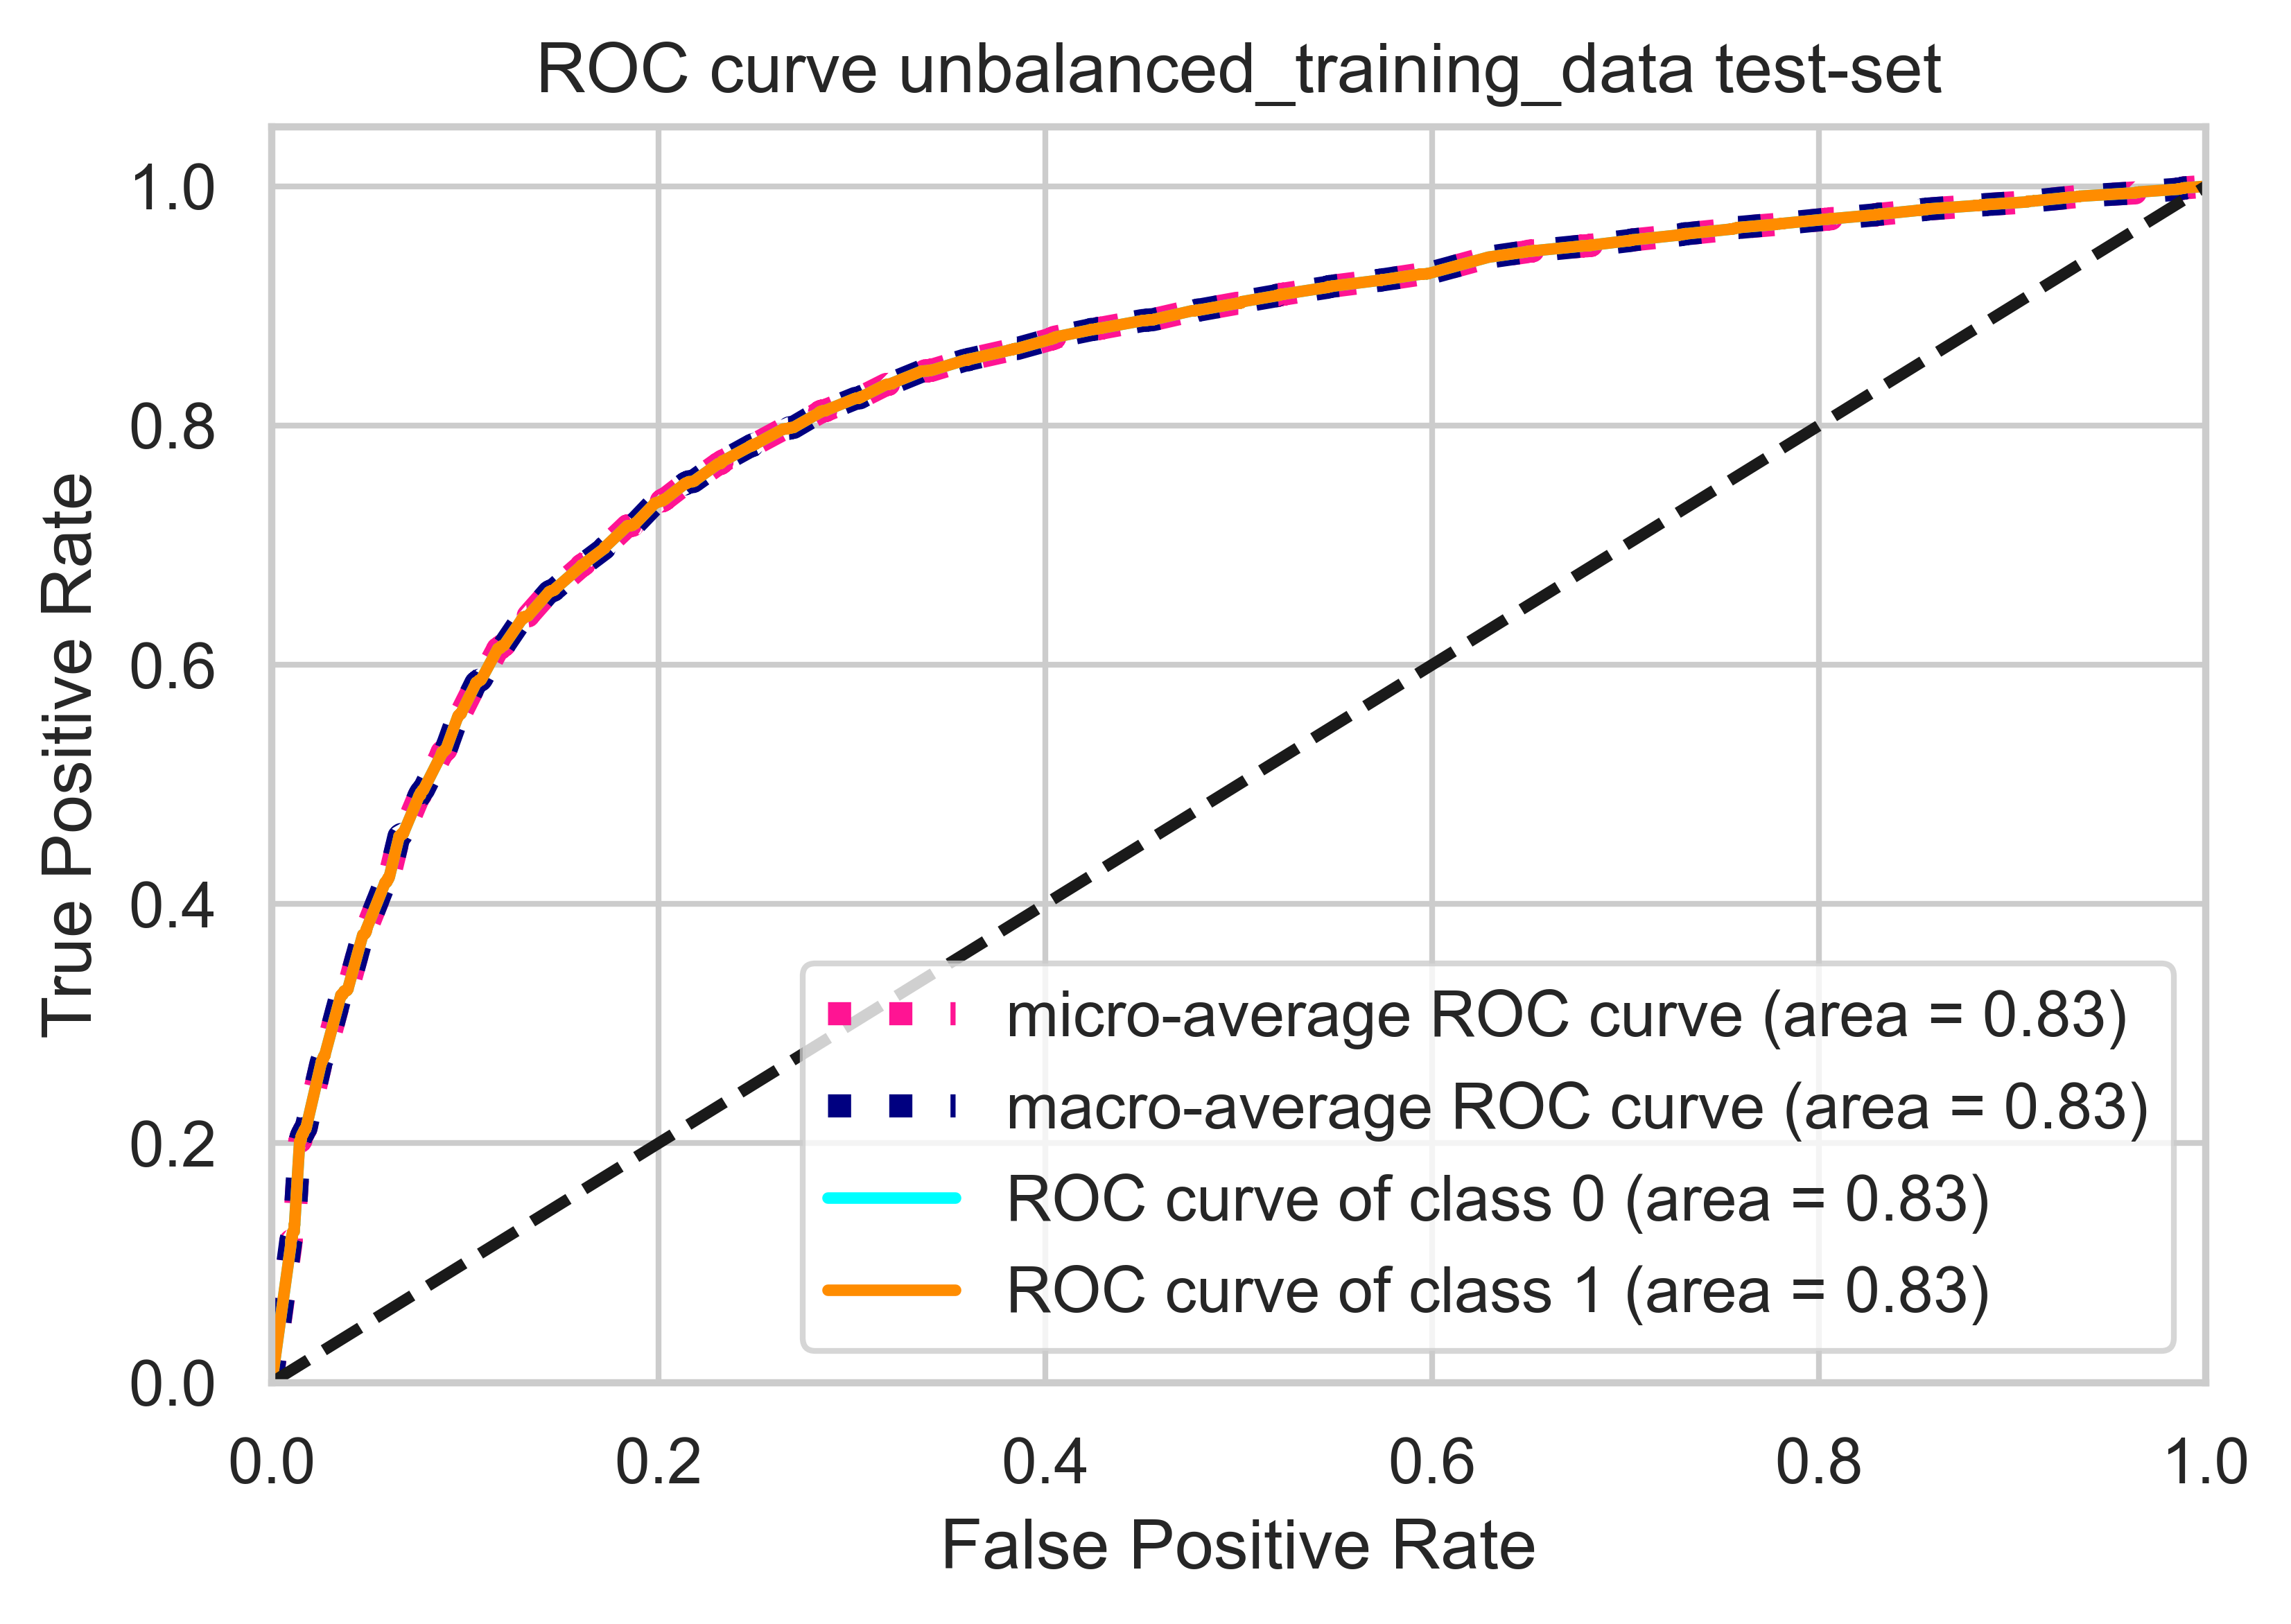

In [48]:
# ploting ROC curve for non-binary class classification

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

def plot_roc_curve(y_test, y_pred, save=False, title=None):
    '''From: https://stackoverflow.com/questions/70278059/plotting-the-roc-curve-for-a-multiclass-problem
    '''
    n_classes = len(np.unique(y_test))
    y_test = label_binarize(y_test, classes=np.arange(n_classes, dtype=int))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    thresholds = dict()
    
    if n_classes > 2:
      for i in range(n_classes):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_test[:, i], y_pred[:, i], drop_intermediate=False)
        roc_auc[i] = auc(fpr[i], tpr[i])
    else:
       for i in range(n_classes):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_test, y_pred, drop_intermediate=False)
        roc_auc[i] = auc(fpr[i], tpr[i])


    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    #plt.figure(figsize=(10,5))
    plt.figure(dpi=600)
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink", linestyle=":", linewidth=4,)

    plt.plot(fpr["macro"], tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy", linestyle=":", linewidth=4,)

    colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "blue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),)

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
    # plt.title("Receiver Operating Characteristic (ROC) curve")
    plt.title(title if title else "Receiver Operating Characteristic (ROC) curve")
    plt.legend()

    if save:
      plt.savefig(f'steam-games-reviews-analysis-sentiment-analysis_ROC-curve_{datetime.now().strftime("%Y%m%d%H%M%S")}.png', dpi=600, facecolor='w')

# for non-binary classification
plot_roc_curve(y_test, predictions_probability, title="ROC curve unbalanced_training_data test-set")

0.8336245533195891


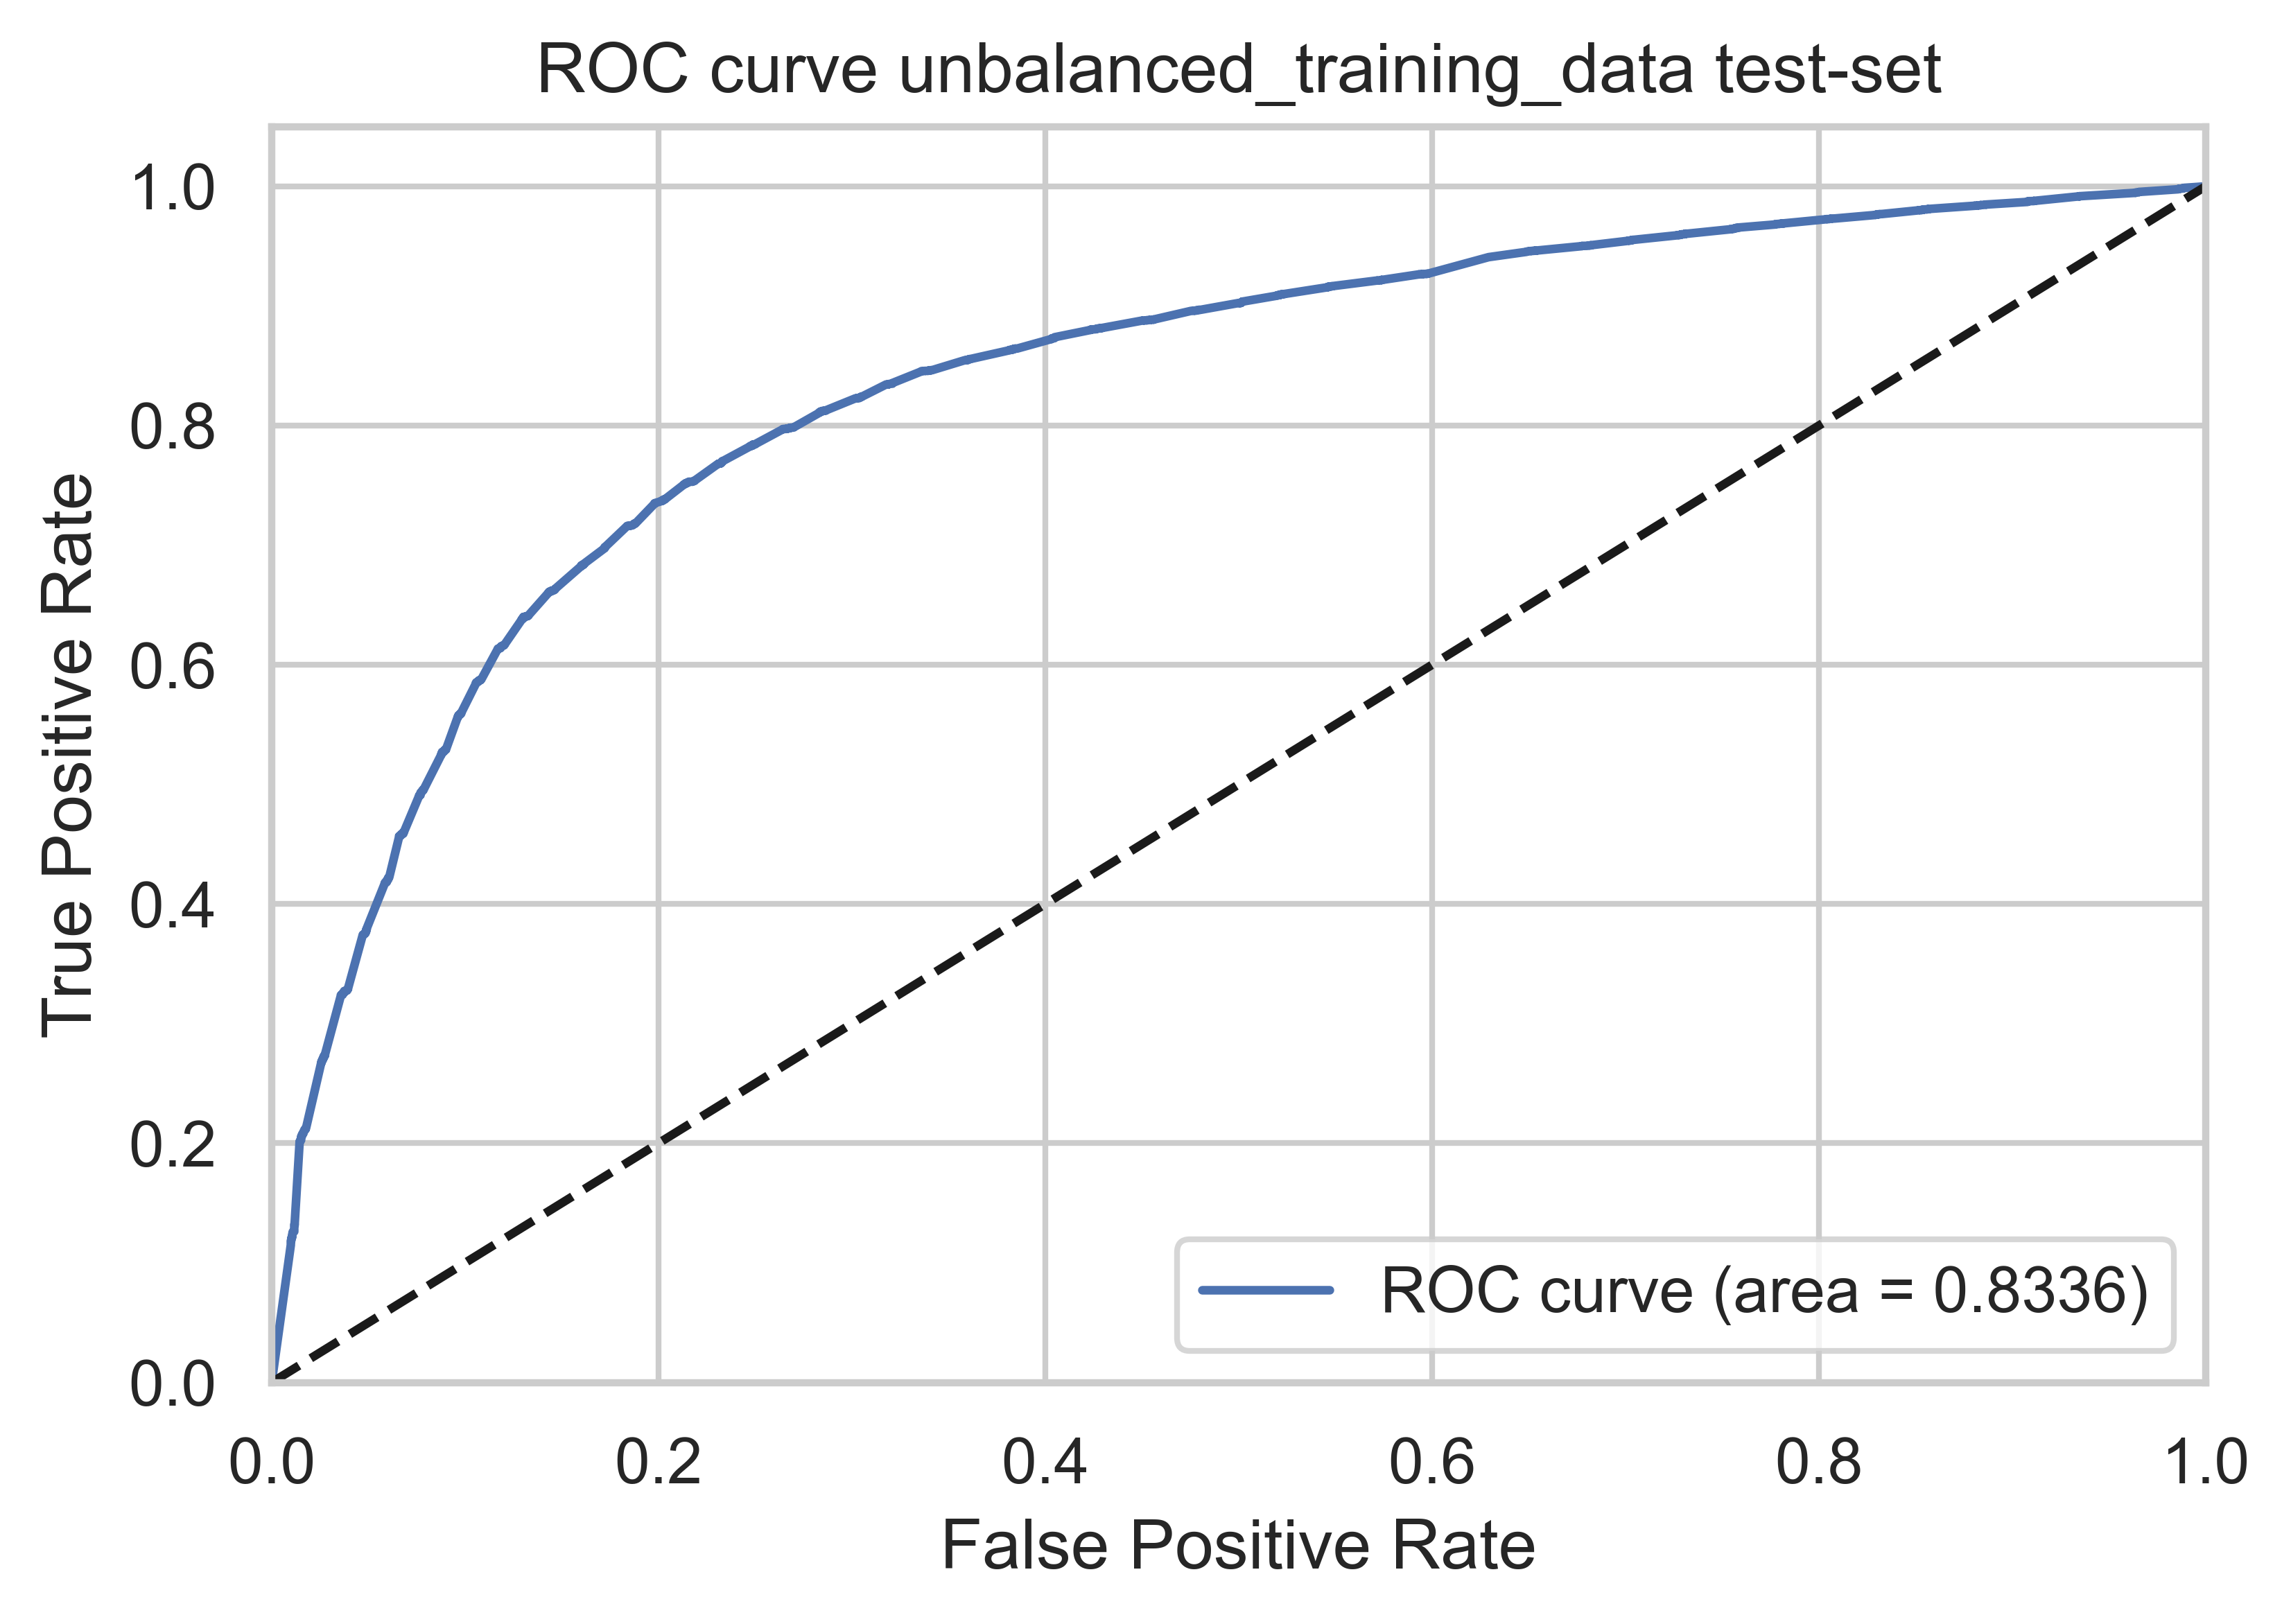

In [49]:
# plot ROC curve for binary class classification

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve_binary(y_test, y_pred, title=None, save=False):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
        roc_auc[i] = auc(fpr[i], tpr[i])

    print(roc_auc_score(y_test, y_pred))
    plt.figure(dpi=600)
    plt.plot(fpr[1], tpr[1], label="ROC curve (area = {:0.4f})".format(roc_auc_score(y_test, y_pred)))

    # random-guess line
    plt.plot([0, 1], [0, 1], "k--")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title if title else 'Receiver operating characteristic (ROC)')
    plt.legend(loc='lower right')

    if save:
        plt.savefig(f'steam-games-reviews-analysis-sentiment-analysis_ROC-curve_{datetime.now().strftime("%Y%m%d%H%M%S")}.png', dpi=600, facecolor='w')

    # plt.show() should come AFTER than plt.savefig
    # as plt.show() clears the whole thing -> anything after wards will happen on a new blank figure
    plt.show()

plot_roc_curve_binary(y_test, predictions_probability, title='ROC curve unbalanced_training_data test-set', save=True)

We see from above confusion matrix that our model has accuracy of 85.6 % and F1-Score of 0.678. It is not good because our data is highly imbalanced. Our model has high accuracy because it computes accuracy of prediction on majority class. After putting our attention to F1-Score, we can understand that our data is poorly at predicting negative class. 

We also have ROC-AUC score of 0.64 (if we just pass the argmax output), or 0.84 (if we pass the probability). So there is a high chance that the our text classifier model WILL NOT be able to distinguish the positive sentiment class values from the negative sentiment class values.

## 5.4. Model's performance validation for larger original dataset

### Here we use our validation data which was taken from 10% of our steam review dataset.

The same dataset will be used in comparing with model trained with balanced dataset.

No balancing should be applied on the validation dataset, as it shall represent the real world usage best 

In [50]:
review_val.review_text = review_val.review_text.astype('str')
#cleaning(review_val,'review_text')

In [51]:
X_val = review_val['review_text']
y_val = review_val['review_score']

In [52]:
# y_pred = text_classifier.predict(X_val)

# get both probability and labels
# the probability is for ploting ROC

predictions_probability_raw = text_classifier.predict_proba(X_val)
# predictions = text_classifier.predict(X_test)
y_pred = np.argmax(predictions_probability_raw, axis=1)

# creating single class label probability for ploting ROC curve
y_pred_prob = predictions_probability_raw if len(np.unique(y_test)) > 2 else np.array([predictions_probability_raw[i, pred] for i, pred in enumerate(list(predictions))])

In [53]:
Confusion_Matrix(y_val,y_pred)

Confusion Matrix: 
               precision    recall  f1-score   support

           0       0.68      0.17      0.27    116329
           1       0.84      0.98      0.91    524658

    accuracy                           0.83    640987
   macro avg       0.76      0.57      0.59    640987
weighted avg       0.81      0.83      0.79    640987



TN - True Negative 19256
FP - False Positive 97073
FN - False Negative 9113
TP - True Positive 515545
Accuracy Rate: 0.8343398540063995
Misclassification Rate: 0.1656601459936005
F1-Score: 0.5863928095554748
ROC-AUC 0.5740805555130258


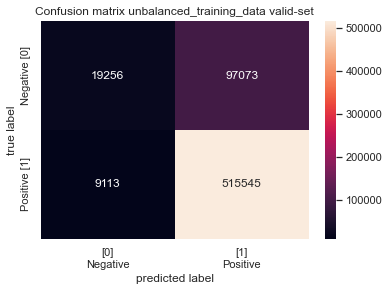

In [57]:
ax = sns.heatmap(confusion_matrix(y_val,y_pred),annot=True,fmt='')

ax.set_title('Confusion matrix unbalanced_training_data valid-set')
ax.set_xlabel("predicted label")
ax.set_ylabel('true label')
ax.set_xticklabels(['[0]\nNegative', '[1]\nPositive'])
ax.set_yticklabels(['Negative [0]', 'Positive [1]'])

save=True
if save:
    plt.savefig(f'steam-games-reviews-analysis-sentiment-analysis_confusion-matrix_{datetime.now().strftime("%Y%m%d%H%M%S")}.png', dpi=600, facecolor='w')

0.8336245533195891


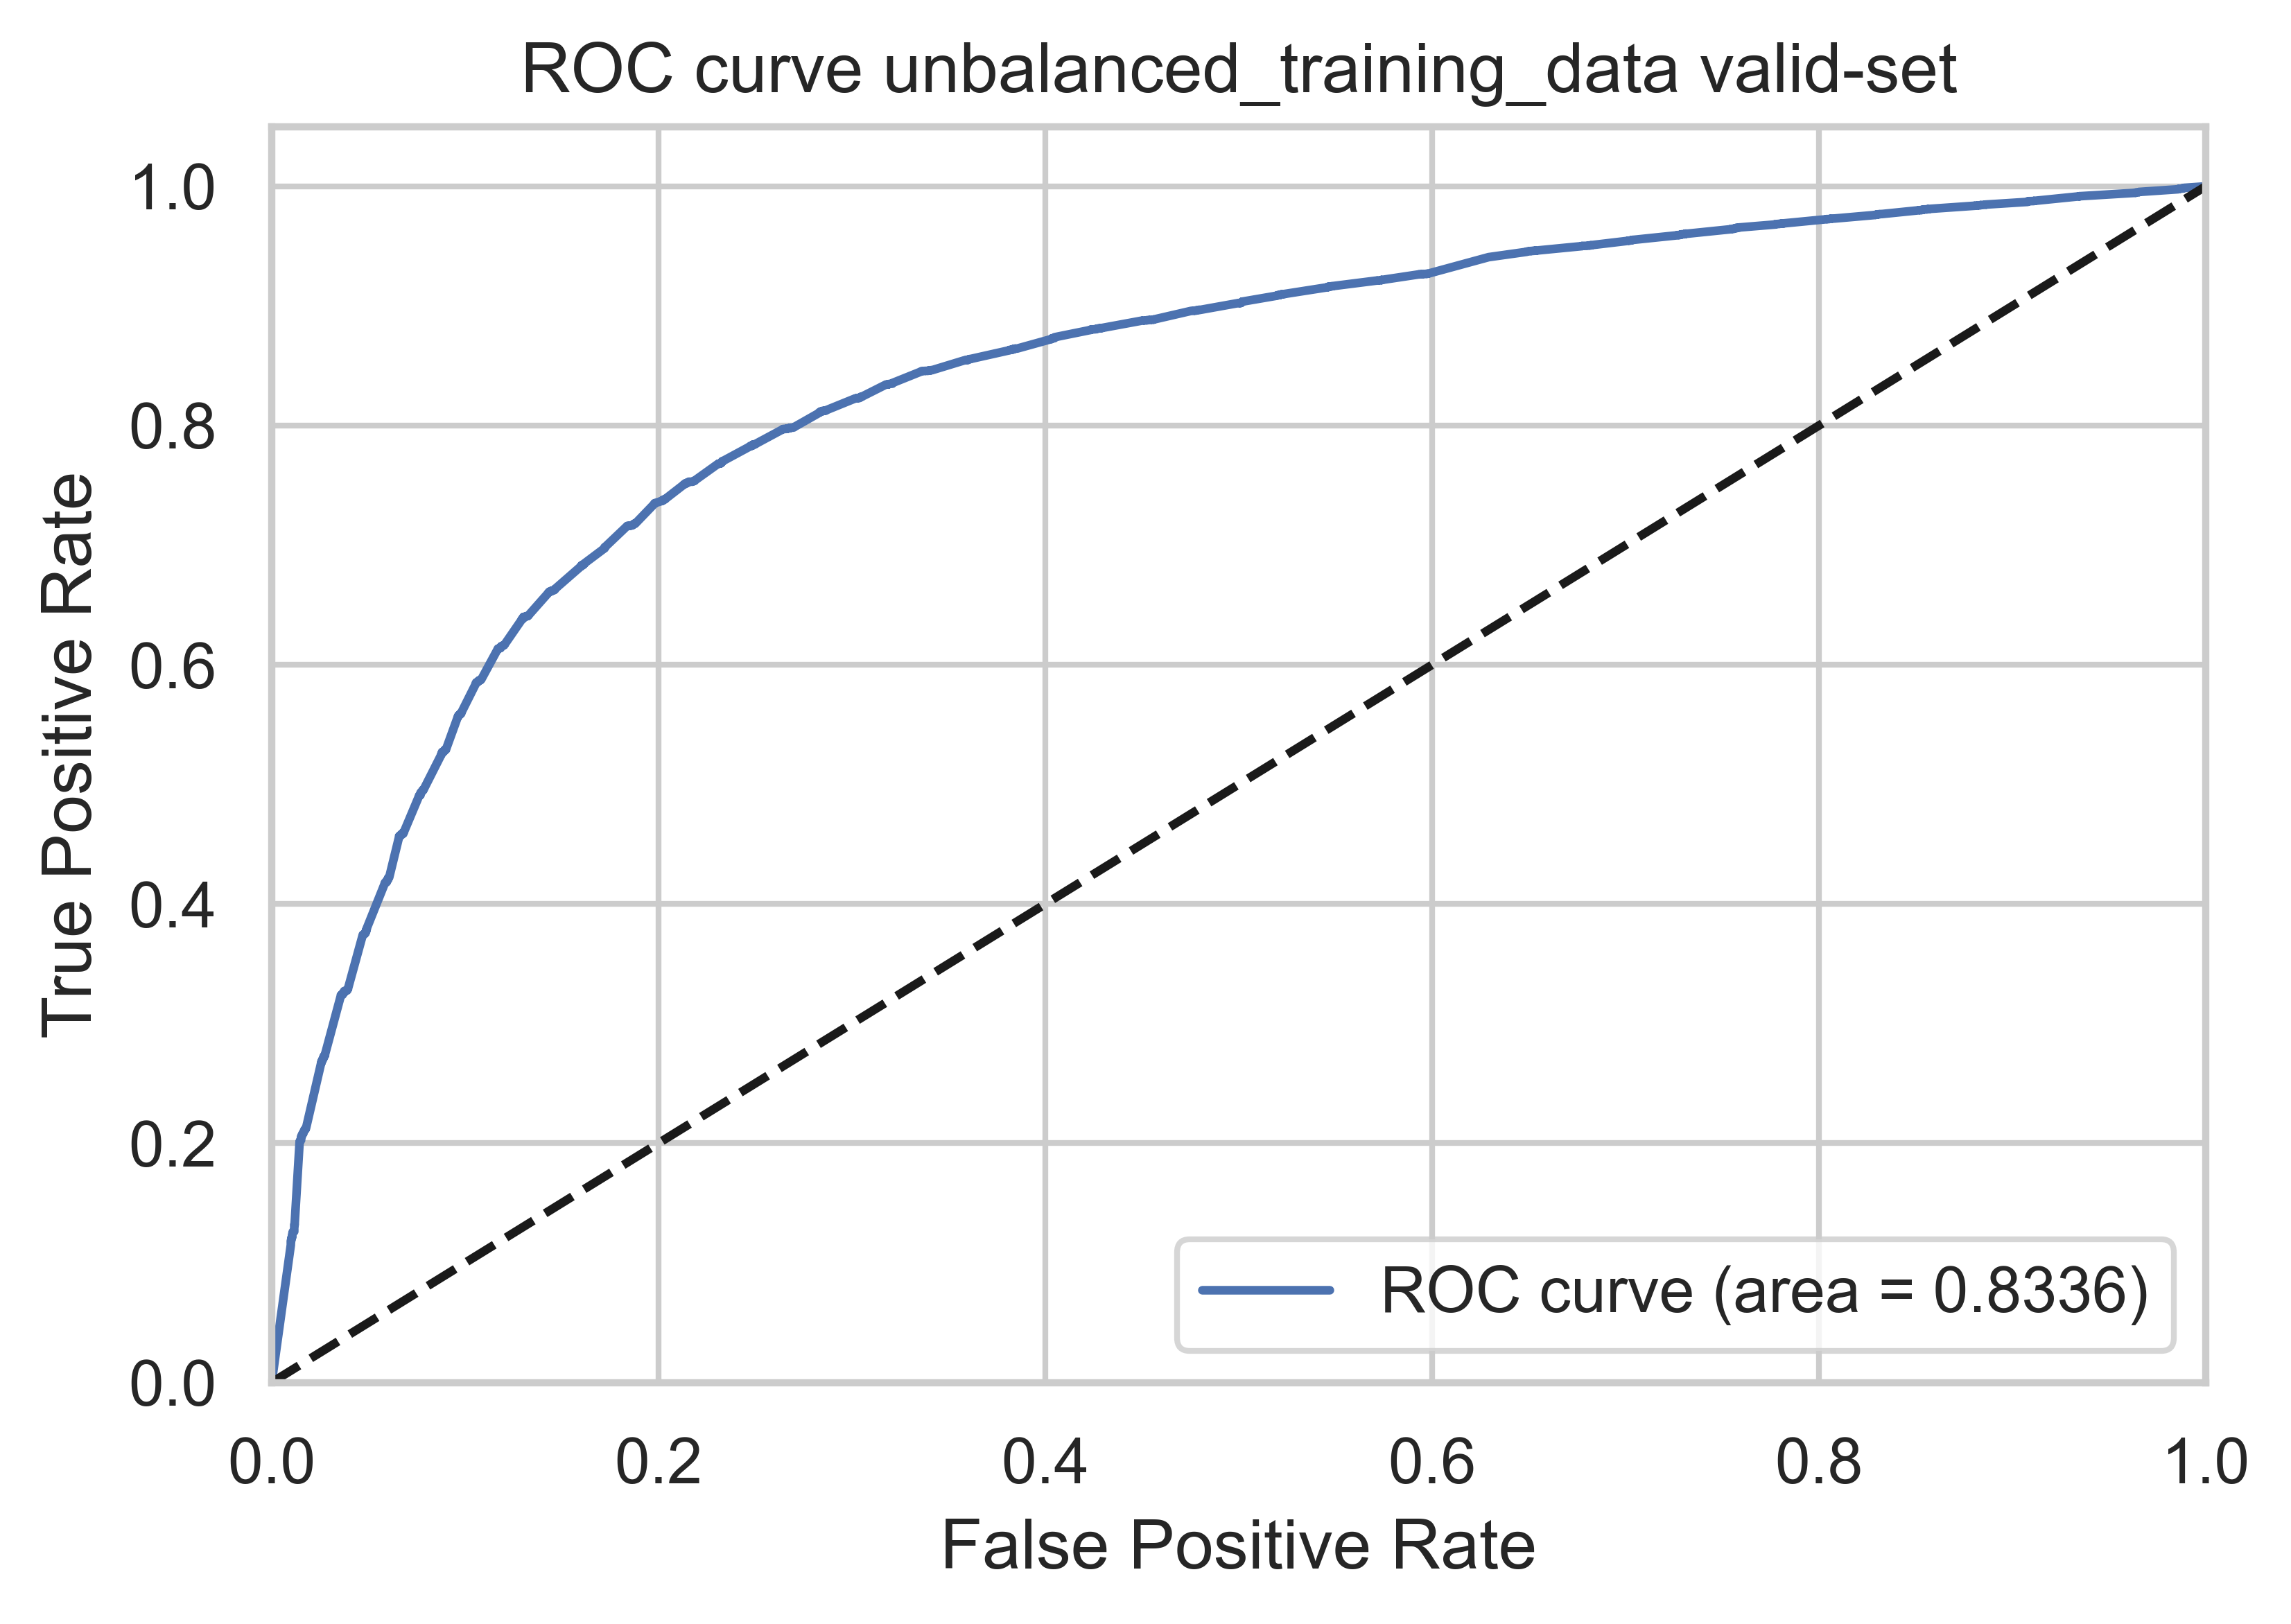

In [55]:
plot_roc_curve_binary(y_test, predictions_probability, title='ROC curve unbalanced_training_data valid-set', save=True)

Same as before, we see from above confusion matrix that our model has accuracy of 83.4% and F1-Score of 0.58. It is not good because our data is highly imbalanced and shows that our text classifier model performed poorly on larger data. 

We also have __ROC-AUC score of 0.57__ (if we just pass the argmax output), or 0.84 (if we pass the probability). So there is a __high chance__ that the our text classifier model will __not be able to distinguish the positive sentiment class values from the negative sentiment class values on larger data.__

## 5.5. Imbalanced Data Classes Handling

### We will use oversampling and undersampling method to handle our imbalanced data.

In [56]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as PL

### Then we set our sampling strategy and variables needed in pipeline

In [58]:
# strategy1 = {-1:40000}
strategy1={0:40000}
strategy2 = {1:40000}

# max_features: If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.
# Otherwise, all features are used.
vect = CountVectorizer(stop_words= "english",max_features=3000)
tfidf = TfidfTransformer()
over = SMOTE(sampling_strategy=strategy1)
under = RandomUnderSampler(sampling_strategy=strategy2)
model = RandomForestClassifier()

In [59]:
# create the dataset

X = review['review_text'].values
y = review['review_score'].values

In [60]:
Counter(y)

Counter({1: 89326, 0: 19749})

Step

- build a CountVectorizer() to count the number of words (term frequency). (and limit your vocabulary size, apply stop words and etc. have to read the docs)  
That is the line _vect.fit(X)_ deos.

- then compute the IDF values by calling tfidf_transformer.fit(word_count_vector) on the word counts we computed earlier.  
That's the line _X = trf.transform(X)_ does

The aformentioned two steps can be combined with _fit_transform()_ function.

fit(): allow the "vector counter" (or other model) to learn the distribution/characteristics of some dataset, return the learnt parameters.

transform(): pass in the original dataset, then apply the "vector counter" (or other model) to the dataset, return the result of applying that model

In [61]:
# trf = vect.fit(X)
# X = trf.transform(X)
X_vectorized = vect.fit_transform(X)

In [62]:
X_vectorized.shape

(109075, 3000)

Then we re-sample the dataset.

The vectorizer is separated from the pipeline object as the fit_resample() only takes the vectorized vectors value as input. String input is not accepted. That's why it's separated

In [63]:
steps = [('over', over), ('under', under)]
pipeline = PL(steps=steps)

In [64]:
X_new, y_new = pipeline.fit_resample(X_vectorized, y)

In [65]:
counter_new = Counter(y_new)
print("Tweet Sentiment Class Proportion after oversampling and undersampling: \n",counter_new)

Tweet Sentiment Class Proportion after oversampling and undersampling: 
 Counter({0: 40000, 1: 40000})


In [66]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_new, y_new,random_state = 40,
                                                   test_size = 0.20)

### Then we run our pipeline and train the model

skip the vectorizer as it has been fit with the unbalanced dataset (which it should). The vectorizer is supposed to learn the distribution/frequency of words in the general dataset, but not the re-balanced dataset, which is a distorted distribution of the general dataset.

In [67]:
pipeline_train = Pipeline([
    # ('vect', vect),
    ('tfidf', tfidf),
    ('model', model),
    ])

In [68]:
text_classifier2 = pipeline_train.fit(X_train2,y_train2)

### Evaluation on testing data

The testing data is a balanced dataset

In [69]:
pipeline_test = Pipeline([
    ('vect', vect),
    ('tfidf', tfidf),
    ('model', model),
])

In [70]:
y_pred2_prob_raw = text_classifier2.predict_proba(X_test2)

y_pred2 = np.argmax(y_pred2_prob_raw, axis=1)

# creating single class label probability for ploting ROC curve
y_pred2_prob = y_pred2_prob_raw if len(np.unique(y_test2)) > 2 else np.array([y_pred2_prob_raw[i, pred] for i, pred in enumerate(list(y_pred2))])

In [71]:
Confusion_Matrix(y_test2,y_pred2)

Confusion Matrix: 
               precision    recall  f1-score   support

           0       0.83      0.82      0.82      7951
           1       0.82      0.83      0.83      8049

    accuracy                           0.83     16000
   macro avg       0.83      0.83      0.83     16000
weighted avg       0.83      0.83      0.83     16000



TN - True Negative 6509
FP - False Positive 1442
FN - False Negative 1337
TP - True Positive 6712
Accuracy Rate: 0.8263125
Misclassification Rate: 0.1736875
F1-Score: 0.8262845365604184
ROC-AUC 0.8262657869399133


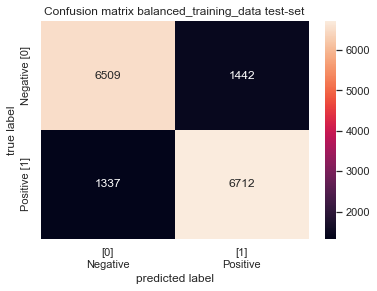

In [72]:
sns.set_style()
ax = sns.heatmap(confusion_matrix(y_test2,y_pred2),annot=True,fmt='')

ax.set_title('Confusion matrix balanced_training_data test-set')
ax.set_xlabel("predicted label")
ax.set_ylabel('true label')
ax.set_xticklabels(['[0]\nNegative', '[1]\nPositive'])
ax.set_yticklabels(['Negative [0]', 'Positive [1]'])


save=True
if save:
    # note that savefig has different settings than ploting in python
    # have to declare it manually
    # https://stackoverflow.com/questions/53727761/black-background-behind-a-figures-labels-and-ticks-after-saving-figure-but-not
    plt.savefig(f'steam-games-reviews-analysis-sentiment-analysis_confusion-matrix_{datetime.now().strftime("%Y%m%d%H%M%S")}.png', dpi=600, facecolor='w')

0.4739178183856554


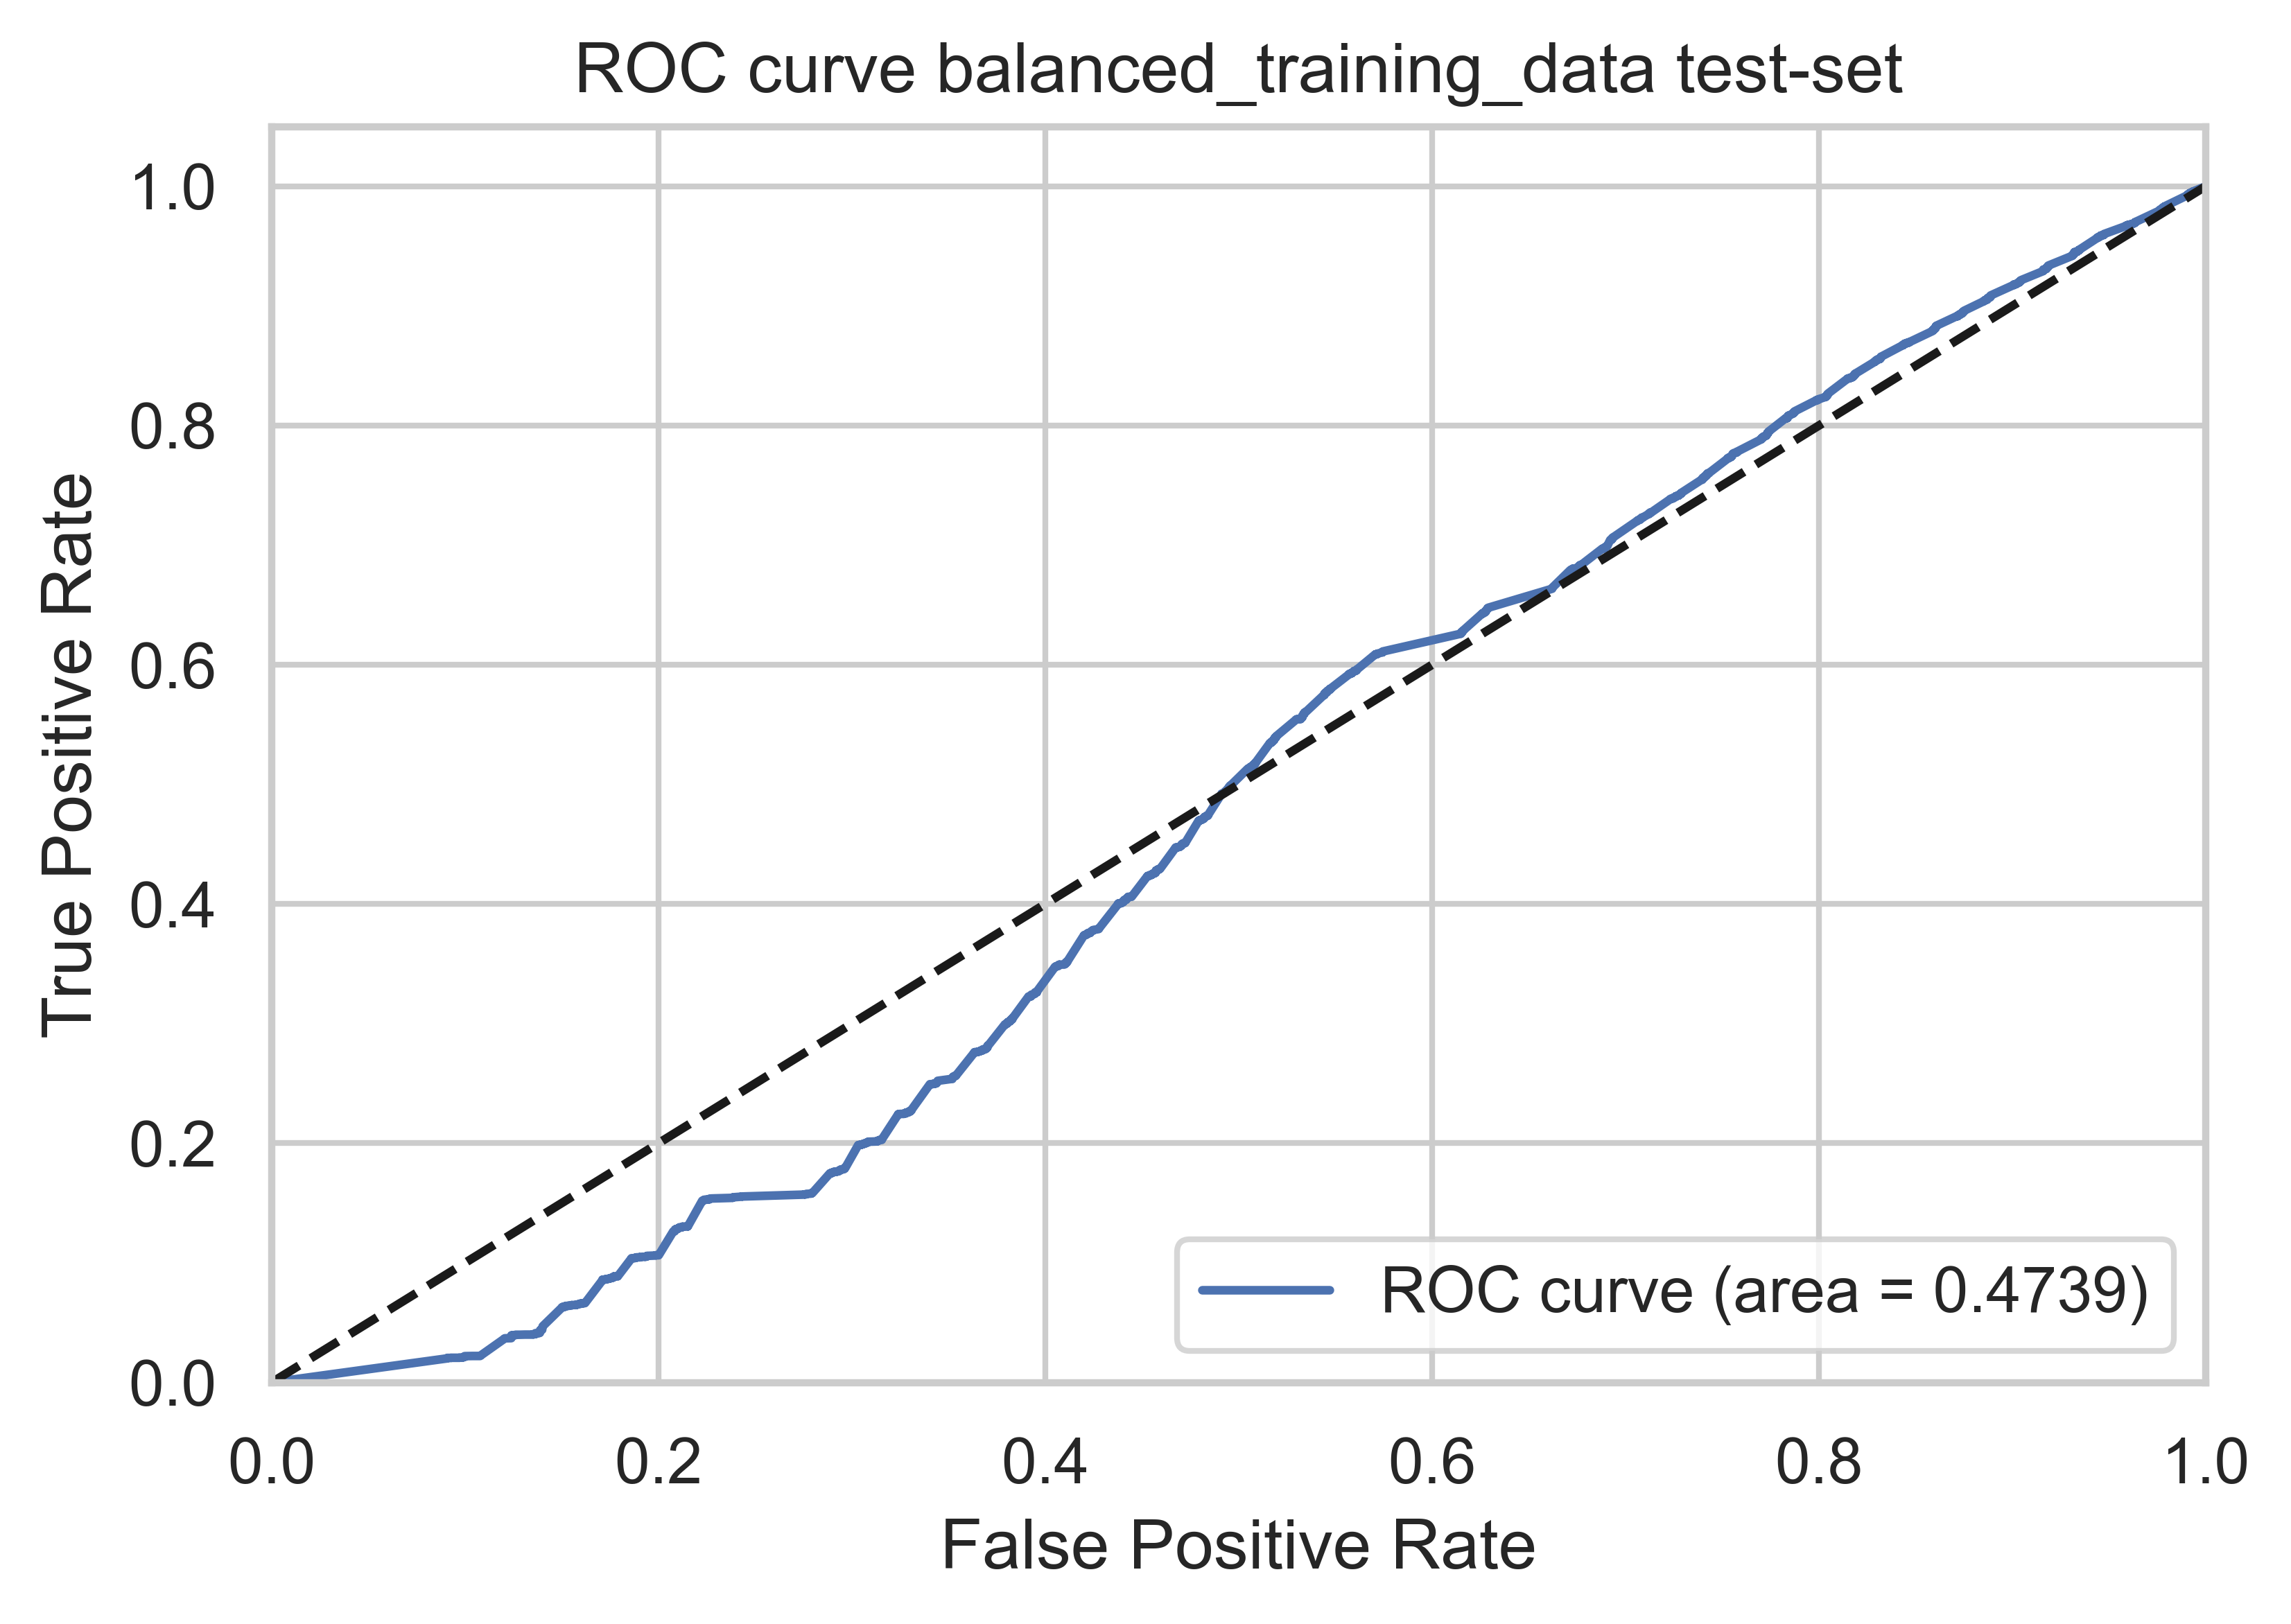

In [73]:
plot_roc_curve_binary(y_test2, y_pred2_prob, title='ROC curve balanced_training_data test-set', save=True)

### Evaluation on original data

Share the same pipeline as testing data

use the same validation data as testing the model trained with unbalanced data

Include the learnt vectorizer. Input will be the cleaned sentence. Output will be the prediction.

In [74]:
# predictions2 = pipeline_test.predict(X_test)

y_val_pred_prob_raw = pipeline_test.predict_proba(X_val)
y_val_pred = np.argmax(y_val_pred_prob_raw, axis=1)

# creating single class label probability for ploting ROC curve
y_val_pred_prob = y_val_pred_prob_raw if len(np.unique(y_val)) > 2 else np.array([y_val_pred_prob_raw[i, pred] for i, pred in enumerate(list(y_val_pred))])

In [75]:
Confusion_Matrix(y_val,y_val_pred)

Confusion Matrix: 
               precision    recall  f1-score   support

           0       0.29      0.71      0.41    116329
           1       0.90      0.61      0.73    524658

    accuracy                           0.63    640987
   macro avg       0.60      0.66      0.57    640987
weighted avg       0.79      0.63      0.67    640987



TN - True Negative 82084
FP - False Positive 34245
FN - False Negative 203904
TP - True Positive 320754
Accuracy Rate: 0.6284651638800787
Misclassification Rate: 0.37153483611992133
F1-Score: 0.5686634735596992
ROC-AUC 0.6584888316310568


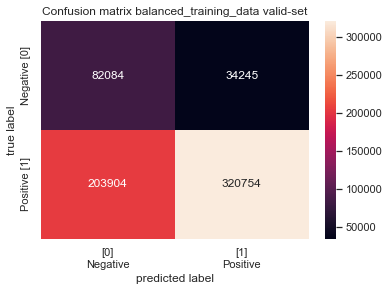

In [76]:
ax = sns.heatmap(confusion_matrix(y_val,y_val_pred),annot=True,fmt='')

ax.set_title('Confusion matrix balanced_training_data valid-set')
ax.set_xlabel("predicted label")
ax.set_ylabel('true label')
ax.set_xticklabels(['[0]\nNegative', '[1]\nPositive'])
ax.set_yticklabels(['Negative [0]', 'Positive [1]'])


save=True
if save:
    plt.savefig(f'steam-games-reviews-analysis-sentiment-analysis_confusion-matrix_{datetime.now().strftime("%Y%m%d%H%M%S")}.png', dpi=600, facecolor='w')

Compare to the model using imbalanced dataset
- Huge increase in identifying True Negative (0, 0), from ~19K -> 81K
- Together with huge decreases from False Negative (1, 0), from ~96K -> 35K
- They come with cost that False Positive (0, 1) increases significantly, from ~9K -> 200K, and a massive decreases in True Positive (515K -> 324K)

The massive increase in False Positive can be the culprit of the ROC curve. Also the accuracy rate decreases very significantly (0.83 -> 0.63).

0.5910305798823268


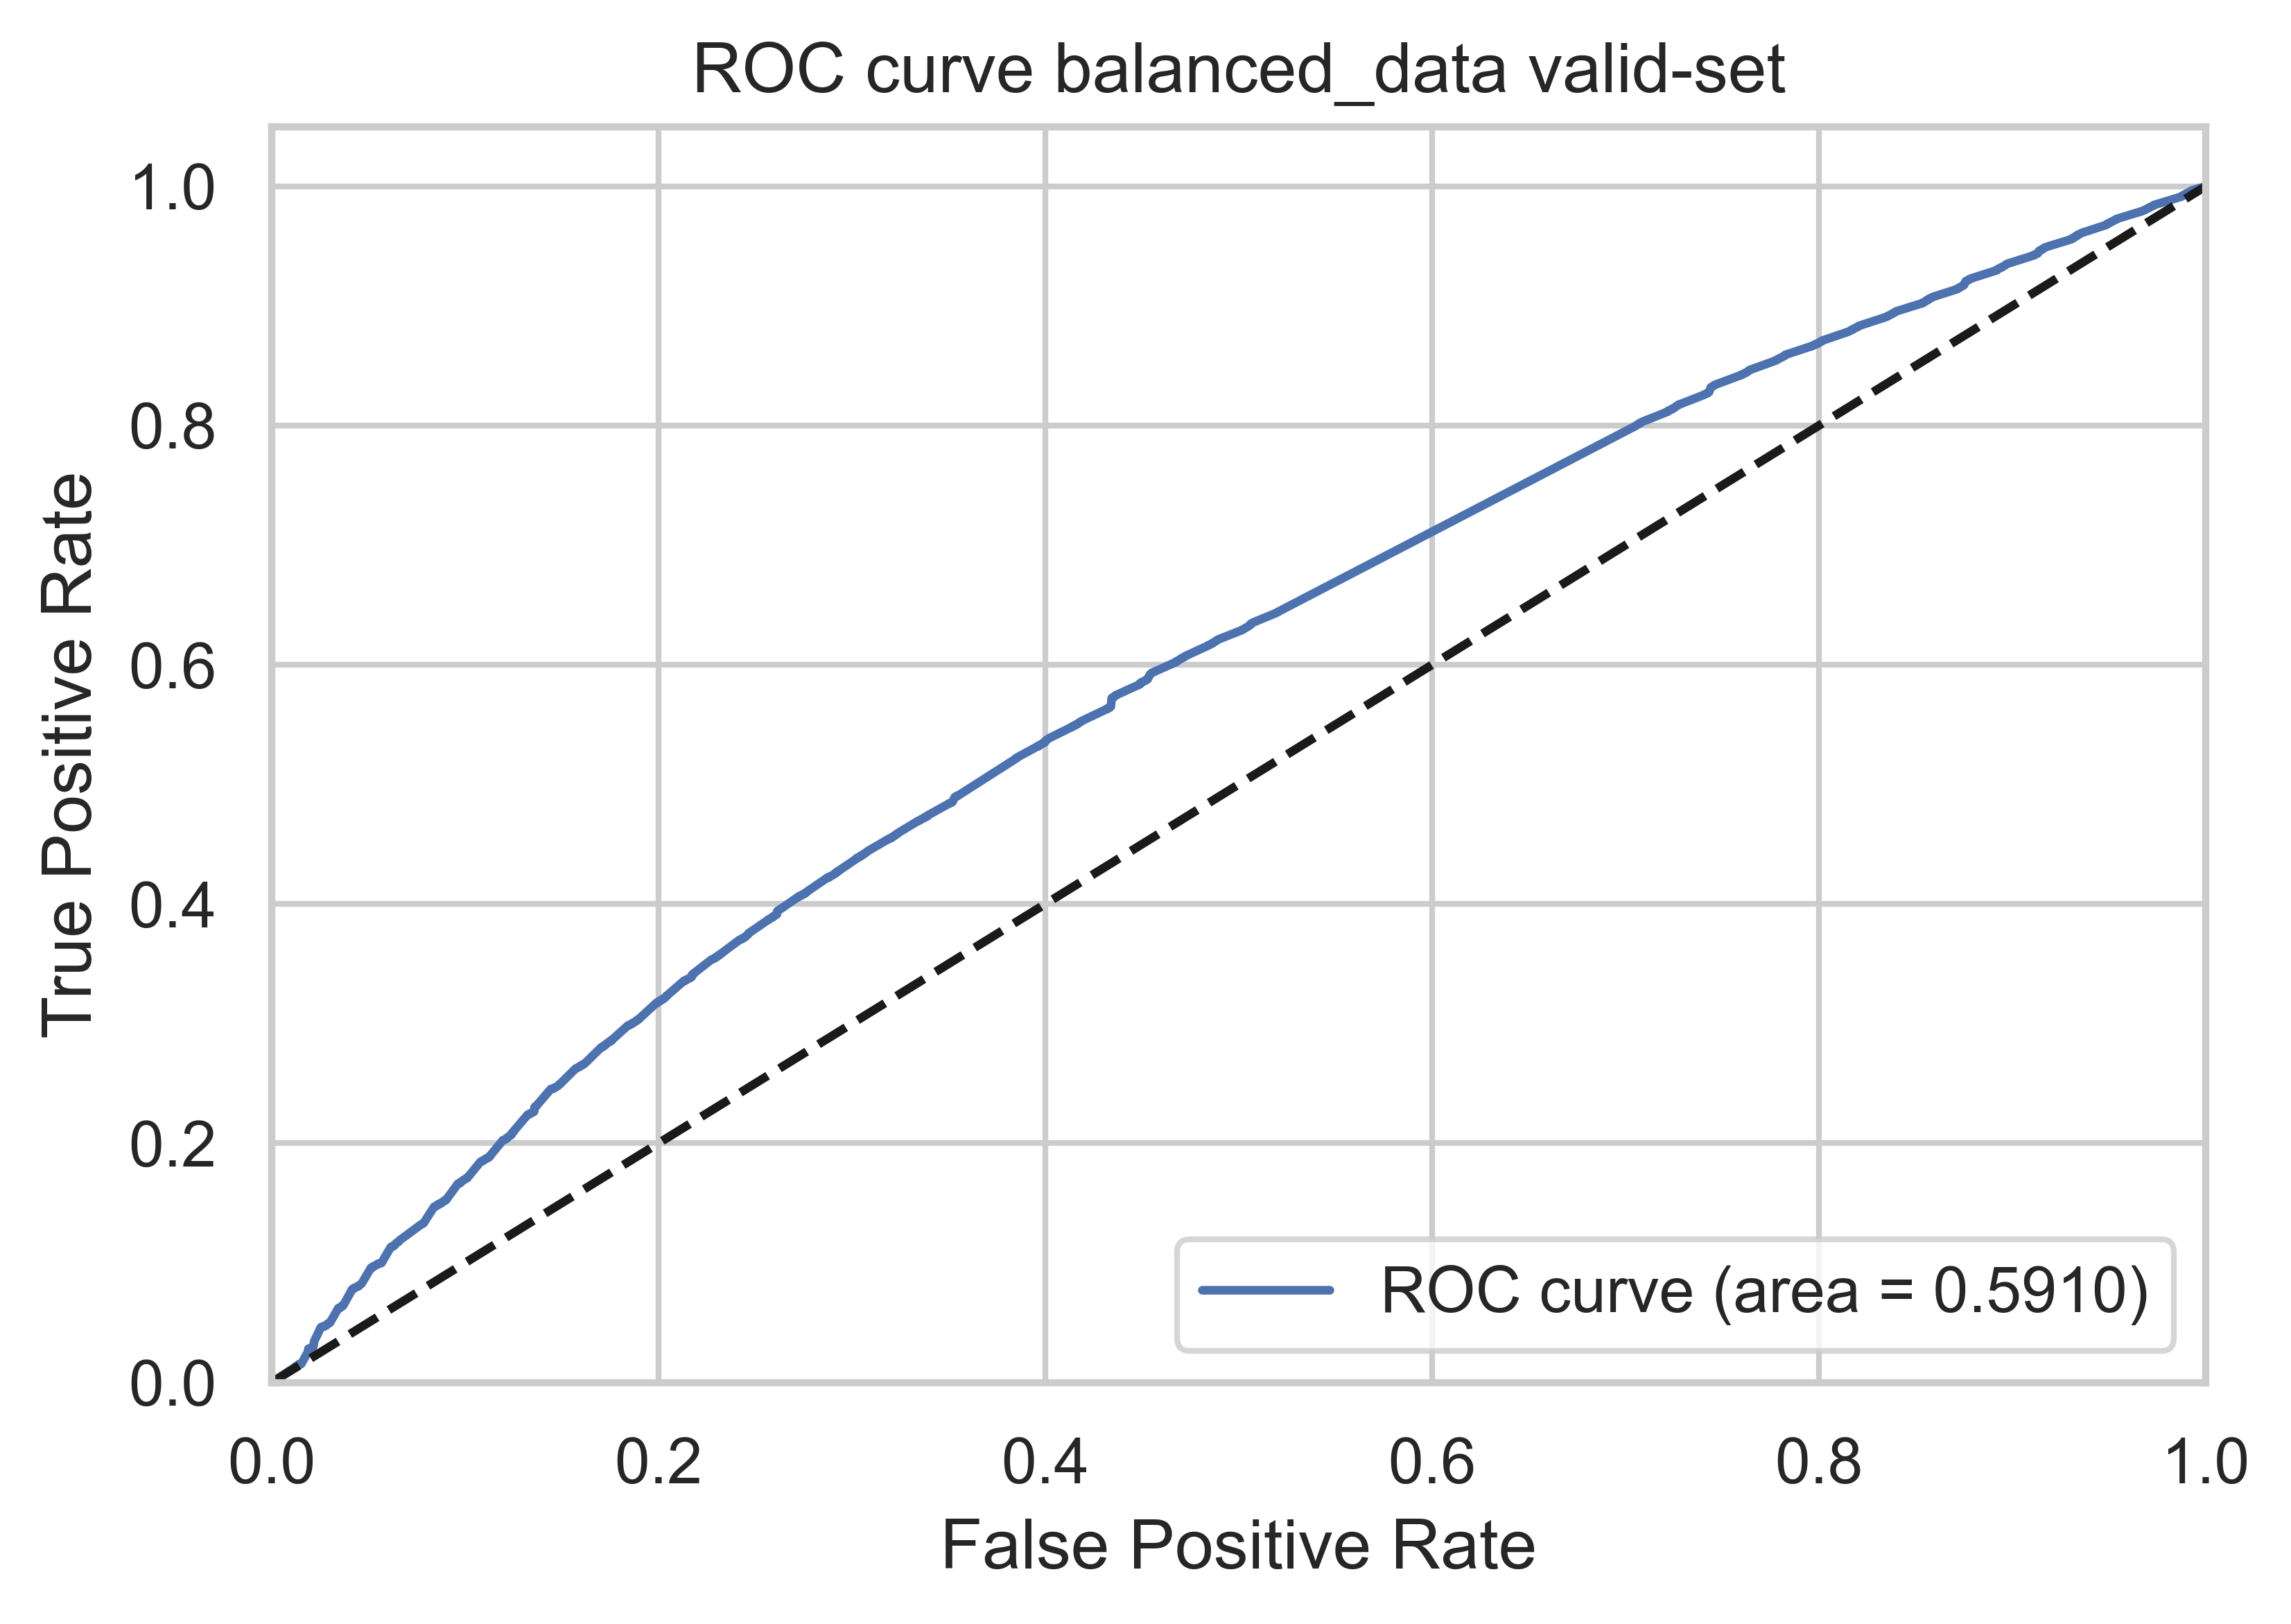

In [78]:
plot_roc_curve_binary(y_val, y_val_pred_prob, title='ROC curve balanced_data valid-set', save=True)

~~Now we got better model after training it on oversampling and undersampling data.~~ 
We got model with accuracy of 0.63, significantly decreased by at least 0.2, and F1-Score of 0.57. The decrease in accuracy is normal, considering the fact that the validation data has inbalanced data distribution, with over 80% reviews are positive. The slight increase in F1-score tells that it 'somehow' better at recognizing True Positive and True Negative labels.

We also have ROC-AUC score of 0.65 (for argmax labelling), or 0.59 (considering probability). ~~So there is a high chance that the our text classifier model WILL be able to distinguish the positive sentiment class values from the negative sentiment class values on larger data.~~

Yet the significant decreases in ROC-AUC score considering probability suggests that the model still fails to identify the sentiment from TD-IDF labelled feature. More powerful model is required.

----------

Model saving

https://stackoverflow.com/questions/58020251/how-to-save-classifier-in-sklearn-with-countvectorizer-and-tfidftransformer

In [79]:
from datetime import datetime
import pickle

# save the model and "trained" tfidf transformer, trained with unbalanced dataset
# so that we can reuse the existing cluster/frequency of the training dataset

# we save the RandomForestClassifier() in section 5.5
filename = Path('steam-games-reviews-analysis-sentiment-analysis_model_unbalanced-data_{}.sav'.format(datetime.today().strftime("%Y-%m-%d")))
pickle.dump(rf_classifier_unbalanced, open(filename, 'wb'))

# we save the count vectorizer in section 5.5 also
filename_count_vec = Path('steam-games-reviews-analysis-sentiment-analysis_count_vectorizer_unbalanced-data_{}.pkl'.format(datetime.today().strftime("%Y-%m-%d")))
pickle.dump(cnt_vect_unbalanced, open(filename_count_vec, "wb"))

# we save the fit tfidf (fit in pipeline2.fit())
filename_tfidf = Path('steam-games-reviews-analysis-sentiment-analysis_tfidf_unbalanced-data_{}.pkl'.format(datetime.today().strftime("%Y-%m-%d")))
pickle.dump(tfidf_unbalanced, open(filename_tfidf, "wb"))

In [80]:
# save the model and "trained" tfidf transformer, trained with balanced dataset
# so that we can reuse the existing cluster/frequency of the training dataset

from datetime import datetime
import pickle


# we save the RandomForestClassifier() in section 5.5
filename = Path('steam-games-reviews-analysis-sentiment-analysis_model_balanced-data_{}.sav'.format(datetime.today().strftime("%Y-%m-%d")))
pickle.dump(model, open(filename, 'wb'))

# we save the count vectorizer in section 5.5 also
filename_count_vec = Path('steam-games-reviews-analysis-sentiment-analysis_count_vectorizer_balanced-data_{}.pkl'.format(datetime.today().strftime("%Y-%m-%d")))
pickle.dump(vect, open(filename_count_vec, "wb"))

# we save the fit tfidf (fit in pipeline2.fit())
filename_tfidf = Path('steam-games-reviews-analysis-sentiment-analysis_tfidf_balanced-data_{}.pkl'.format(datetime.today().strftime("%Y-%m-%d")))
pickle.dump(tfidf, open(filename_tfidf, "wb"))

Self testing the model. Building a demo pipeline.

Input: a sentence
Output: a sentiment score.



In [83]:
# load the model

import pickle
from pathlib import Path

filename = Path("steam-games-reviews-analysis-sentiment-analysis_model_balanced-data_2023-10-23.sav")
loaded_model = pickle.load(open(filename, 'rb'))

# we save the count vectorizer in section 5.5 also
filename_count_vec = Path('steam-games-reviews-analysis-sentiment-analysis_count_vectorizer_balanced-data_2023-10-23.pkl')
loaded_count_vec = pickle.load(open(filename_count_vec, "rb"))

# we save the fit tfidf (fit in pipeline2.fit())
filename_tfidf = Path('steam-games-reviews-analysis-sentiment-analysis_tfidf_balanced-data_2023-10-23.pkl')
loaded_tfidf = pickle.load(open(filename_tfidf, "rb"))


re-build the end-to-end pipeline

from data-cleaning to output

In [84]:
from sklearn.pipeline import Pipeline

def cleaning(s_list:list[str]):
    '''Apply text cleaning to a list of texts before passing to the model
    '''
    _s_list = list(map(clean, s_list))
    _s_list = list(map(deEmojify, _s_list))
    _s_list = list(map(lambda x: x.lower(), _s_list))
    _s_list = list(map(remove_num, _s_list))
    _s_list = list(map(remove_symbols, _s_list))
    _s_list = list(map(remove_punctuation, _s_list))
    _s_list = list(map(remove_stopword, _s_list))
    _s_list = list(map(unify_whitespaces, _s_list))
    _s_list = list(map(stemming, _s_list))
    return _s_list

pipeline_loaded = Pipeline([
    ('count_vectorizer', loaded_count_vec),
    ('tfidf', loaded_tfidf),
    ('model', loaded_model)    
])

In [85]:
X_test

29994                  game realli awesom best shooter game
122758                          go one hole come anoth hole
110100                                  earli access review
85555     well telltal made anoth episod game tale borde...
62839     game borderlin one ultim come side recommend t...
123426    think anyth good say game even snipe right ela...
58796     play bit like thus far like light atmospher da...
60905     realli glad see game brought back life special...
69667     hilari amaz enjoy got appl ii vibe perfect fre...
1681                                         much fun illeg
8038      play game sinc beta play mod communiti went hi...
66382                      amaz game defin would reccommend
83513     play player control say press f h e doubl hock...
127860                 game realli cool fun u get look kdzu
109480    moment let forget fact latest unassail exampl ...
89092     brief yes complet satisfi can not wait inmind ...
40410     one best game ever play know g

In [86]:
predictions_from_loaded = pipeline_loaded.predict(X_test)

In [87]:
Confusion_Matrix(y_test,predictions_from_loaded)

Confusion Matrix: 
               precision    recall  f1-score   support

           0       0.62      0.94      0.75      3951
           1       0.98      0.88      0.93     17864

    accuracy                           0.89     21815
   macro avg       0.80      0.91      0.84     21815
weighted avg       0.92      0.89      0.89     21815



TN - True Negative 3698
FP - False Positive 253
FN - False Negative 2229
TP - True Positive 15635
Accuracy Rate: 0.8862250744900297
Misclassification Rate: 0.1137749255099702
F1-Score: 0.8375990893115013
ROC-AUC 0.905594746175808


<Axes: >

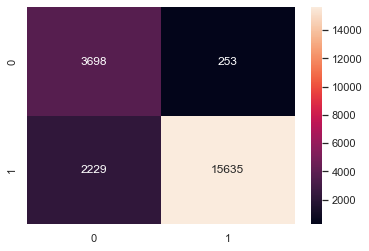

In [88]:
sns.heatmap(confusion_matrix(y_test,predictions_from_loaded),annot=True,fmt='')

The result matches with the previous testing pipeline.

In [89]:
pipeline_loaded.predict(['This game is freaking good! I enjoy the graphics.'])

array([1])

In [90]:
pipeline_loaded.predict(['GOAT !!'])

array([1])

In [91]:
pipeline_loaded.predict(['This game feels not good at the graphics.'])

array([0])